# Group project


### Predicting subscription status of plaicraft players

### Introduction

#### Background

A research group in Computer Science at UBC is collecting data about how people play video games. Based on the data set, our group want to know what player characteristics and behaviours are most predictive of subscribing to a game-related newsletter and how do these features differ between various player types. After analysising the data set, we choose to foucus on experience and play hours to each plays to predict they subscribe newsletter or not.

#### question

Can experience and play hours to each player predict an individual subscribes or not in player dataset?

#### data description

(1) the number of observations: 196

(2) content of the data: personal information amd information related to game experience of players

(3) number of variables: 7

(4) name and type of variables: experience <chr> (character), subscribe <lgl> (logics), hashedEmail <chr> (character)
                            played_hours <dbl> (number),  name <chr> (character),	gender <chr> (character), Age <dbl> (number)

(5) meaning of each variable:

experience: the palyer's previous game experience, their familar levels to game.

subscribe: does the player subscribe the game or not

hashedEmail: the email for further contact 

play_hours: the hours that each play spend on game (each week)

### Methods & Results

In [5]:
library(tidyverse)
library(tidymodels)
#Required packages.

raw_data <- read_csv("https://raw.githubusercontent.com/liujianan-2005/dsci100-group-project/refs/heads/main/players.csv") #Loads data set.
head(raw_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [6]:
player_mean <- raw_data |>
                summarize (played_hours_mean = mean(played_hours, na.rm = TRUE),
                            age_mean = mean(Age, na.rm = TRUE))
player_mean

played_hours_mean,age_mean
<dbl>,<dbl>
5.845918,20.52062


In [13]:
experience_levels <- c("Beginner" = 0, "Amateur" = 1, "Regular" = 2, "Veteran" = 3, "Pro" = 4)
   #Quantifies the experience levels from 0-4 
     #(Although experience is ordinal, we will assume interval relationship).

data <- raw_data |> 
    select(experience, subscribe, played_hours) |>
    mutate(experience = as.numeric(factor(experience, levels = names(experience_levels), labels = experience_levels))) |>
    mutate(subscribe = as_factor(subscribe))
        #Modifies the database to ensure all columns is the correct type.
head(data)

experience,subscribe,played_hours
<dbl>,<fct>,<dbl>
5,TRUE,30.3
4,TRUE,3.8
4,FALSE,0.0
2,TRUE,0.7
3,TRUE,0.1
2,TRUE,0.0


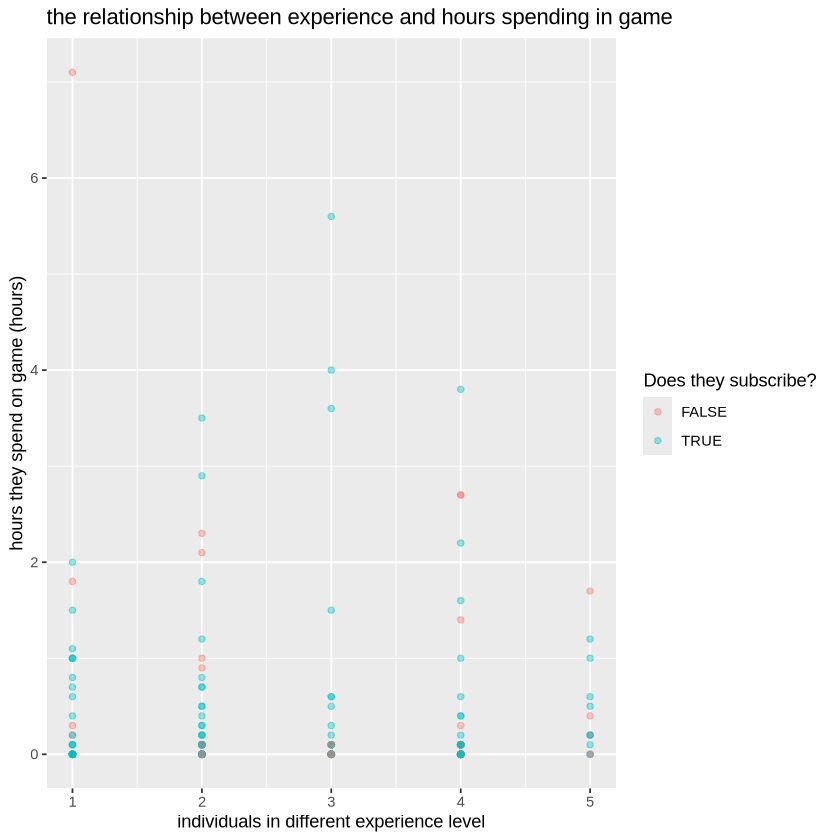

In [29]:
data_graph <- data |>
        filter(played_hours < 10)
exp_play_plot <- data_graph |>
    ggplot(aes(x = experience, y = played_hours, color = subscribe)) + 
        geom_point(alpha = 0.4) + 
        labs(x = "individuals in different experience level",
             y = "hours they spend on game (hours)",
             color = "Does they subscribe?",
             title = "the relationship between experience and hours spending in game")
exp_play_plot

In [30]:
set.seed(20) #Sets a seed so that randomness is the same across attempts.
split <- initial_split(data, prop = 0.75, strata = subscribe)
train_data <- training(split)
test_data <- testing(split)
#Splits the original data to train and test our model.

In [31]:
cv_folds <- vfold_cv(train_data, v = 5, strata = subscribe)

knn_spec <- nearest_neighbor(neighbors = tune()) |> 
  set_engine("kknn") |> 
  set_mode("classification")
#Creates the model we will like to train.

knn_recipe <- recipe(subscribe ~ experience + played_hours, data = train_data) |> 
  step_scale(all_predictors())
#Scales predictors so that each predictor holds equal weight on determining subsription status.

knn_workflow <- workflow() |> 
  add_recipe(knn_recipe) |> 
  add_model(knn_spec)

knn_grid <- tibble(neighbors = seq(1, 30, by = 1))
#Creates a new column that will allow R to assign accuracy for each tested K to find best K.

knn_results <- tune_grid(
  knn_workflow,
  resamples = cv_folds,
  grid = knn_grid,
  metrics = metric_set(accuracy))

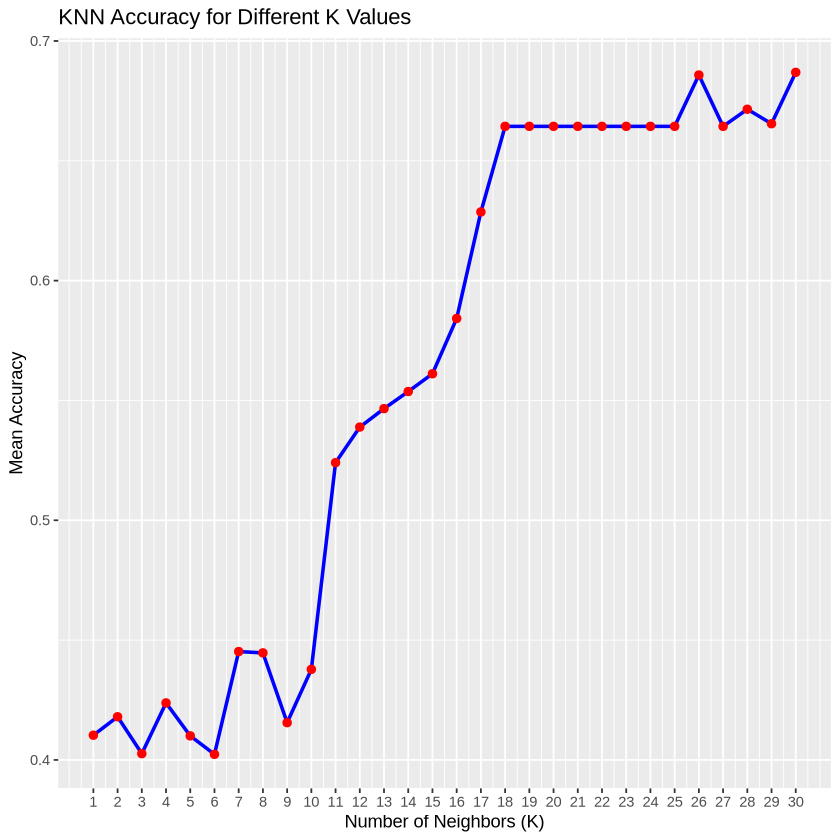

In [32]:
knn_metrics <- knn_results |> 
  collect_metrics()

knn_metrics_plot <- knn_metrics|> 
  filter(.metric == "accuracy") |> 
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "red", size = 2) +
  labs(title = "KNN Accuracy for Different K Values",
    x = "Number of Neighbors (K)",
    y = "Mean Accuracy") +
    scale_x_continuous(breaks = 1:30) 
knn_metrics_plot

In [33]:
best_k <- knn_results |> select_best("accuracy")
best_k
#Identifies the best K-value.
final_knn_spec <- nearest_neighbor(neighbors = best_k$neighbors) |> 
            set_engine("kknn") |> 
            set_mode("classification")
#Creates the final model based on the optimal number of neighbours we should use.

final_knn_workflow <- knn_workflow |> 
    finalize_workflow(best_k) |> 
    fit(data = train_data)

final_predictions <- predict(final_knn_workflow, new_data = test_data) |> 
    bind_cols(test_data)
#Uses the testing set created earlier to determine the accuracy of the model.

conf_matrix <- conf_mat(final_predictions, truth = subscribe, estimate = .pred_class)
conf_matrix
#Prints a table that shows the results of the test.


accuracy_score <- accuracy(final_predictions, truth = subscribe, estimate = .pred_class)
accuracy_score
#Prints out the accuracy of the model based on the results.

neighbors,.config
<dbl>,<chr>
30,Preprocessor1_Model30


          Truth
Prediction FALSE TRUE
     FALSE     1    3
     TRUE     12   30

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.673913


A code is written to develop an engine that will predict the subsription status of a new individual based on its standardized experience level and hours played. The first step of the code is to download necessary packages and the database itself. This is then followed by modifying the database into a format that will allow us to effectively create a model. This includes mutating experience levels into an interval scale and change the type of data the columns are. Before traning the model, we split the original database into two, 75% traning and 25% testing. 
To train the model, we use cross-validation from the traning set to find the best K-value that will five us the best accuracy. This step involves spliting the testing set into more splits.
Finally, once the optimal K-value is found, we use the testing set to test the accuracy of the model.

By training the model, we found that a K-value of 28 is optimal. This suggests that we are most likely to correctly identify an individual's subscription status using which status appears most often when using 28 of its nearest neighbours. Additionally, our test gave an accuracy of 69%. This suggests that, although our model can correctly predict an individual's status majority of the time, there is still 31% chance it will predict incorrectly.

### Discussion

We found that the best k value is 30 because it shows the highest accuracy in cross-validation in training data. And we get the accuracy in testing data when k is equal to 30 is 67.3%. It means that KNN classification model can correctly classify 67.3% of the plater data using experience and play hours.

An accuracy of 67.3% is decent, but it does not indicate a strong association, as there is still a 32% margin for improvement.It is a little bit lower than we expect but it is acceptable. It indicates that experience and play hours are effective predictors of whether the majority of players subscribe to game newsletters. 

Based on our finding, we are able to predict a player subscribe game newsletters or not just know their play hours in game each week and their previous game related experience in furture.

We categorize experience into different numerical levels and used as a predictorin our classification model. Rather than scalling experience levels in an interval scale, meaning there is an equal distance between each experience level, future models can attempt to design a method that better seperates experience to better represent the true difference between levels. For example, the level of experience can be divided in more details so that it can be devided into a broader range. The result will be more accurate with broader range in predictor.